Many-Body Chern Number without Integration

Koji Kudo, Haruki Watanabe, Toshikaze Kariyado, and Yasuhiro Hatsugai

Phys. Rev. Lett. 122, 146601 – Published 9 April 2019

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.146601

In [1]:
using QuantumOptics
using NBInclude
using Einsum
using DataFrames
using LinearAlgebra
# lattice
@nbinclude("Lattice_Basis_Neighbors_Hops.ipynb"; regex=r"#.*executeme")
# mb tools
@nbinclude("QOJulia_utils.ipynb")
# chern 
@nbinclude("Chern_utils.ipynb")

calc_all_states_H_mb_2 (generic function with 1 method)

# Parameters

In [2]:
param_dict=Dict{}()

LL = [3,3]
N = LL[1]*LL[2]
vv_lattice = [ [1., 0], [0, 1.] ]
b1=[0, 0]
vv_basis = [b1]
param_dict["N"] = LL[1]*LL[2]

param_dict["LL"] = LL
param_dict["vv_lattice"] = vv_lattice
param_dict["vv_basis"] = vv_basis

nb=1 # number of basis
t=-1 # hopping amplitude
p=1
q=LL[2]
ϕ=p/q # magnetic flux per plaquet
param_dict["gauge"] = "Landau"
param_dict["t"]=t
param_dict["ϕ"]=ϕ
θθ = [0, 0] # initial values for twist angles
param_dict["θθ"]=θθ

sites, site_coord, site_number = get_sites(LL, vv_lattice, vv_basis);
param_dict["sites"] = sites
param_dict["site_coord"] = site_coord
param_dict["site_number"] = site_number

pbc=true # periodic boundary condition
param_dict["pbc"] = pbc
neighbors = [ [1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]  ]
neighbors_list = [ neighbors ]
param_dict["neighbors_list"] = neighbors_list

# size of parameter space
N1 = 15
N2 = 15
dx=2*pi/N1
dy=dx
Tx=collect(range(start=0, stop=2*pi-dx, step=dx))
Ty=collect(range(start=0, stop=2*pi-dy, step=dy));

param_dict["Tx"] = Tx
param_dict["Ty"] = Ty;

# 1) Single Particle

In [3]:
basis = NLevelBasis(N) 
param_dict["basis"] = basis;

param_dict["model_H1"] = get_Hofstadter_hamiltonian

H_T = get_Hofstadter_hamiltonian(param_dict)
H1 = get_sp_op(basis, H_T)

EE, UU = eigenstates(dense(H1));

## 1.1) Single Particle Chern

In [4]:
param_dict["param_1"] = "Tx"
param_dict["param_2"] = "Ty"
EEA_0, UUA_0 = calc_all_states_H1(param_dict);

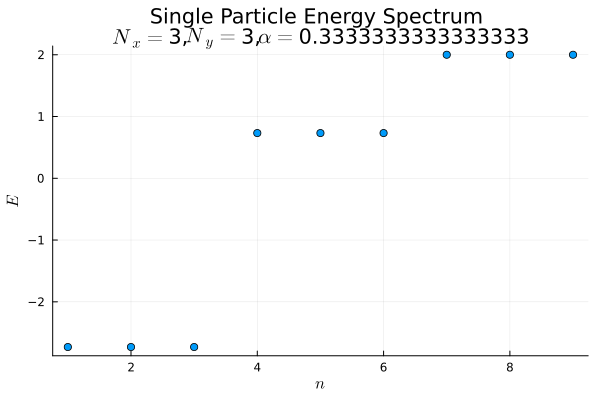

In [5]:
using Plots
using LaTeXStrings
scatter(real(EEA_0[1,1,:]),legend = false,title="Single Particle Energy Spectrum \n"*L"N_x="*"$(LL[1]),"*L"N_y="*"$(LL[2]),"*L"\alpha="*"$(p/q)", xlabel=L"n",ylabel=L"E")

In [6]:
EEA_0[1,1,:]

9-element Vector{Float64}:
 -2.7320508075688728
 -2.732050807568871
 -2.732050807568871
  0.7320508075688776
  0.7320508075688779
  0.7320508075688781
  1.9999999999999998
  1.9999999999999998
  2.0000000000000004

In [8]:
bands = [[1,3],[4,6],[7,9]]
#bands = [[1,4],[5,8],[9,12],[13,16]]
#bands = [[1,5],[6,10],[11,15],[16,20],[21,25]] # 5x5
Chern, F12list = calc_chern_bands(UUA_0, bands)
Chern

3-element Vector{Any}:
                1.0 - 1.2561547394593865e-17im
               -2.0 - 1.4156505320489692e-16im
 0.9999999999999999 + 1.7283963939956817e-16im

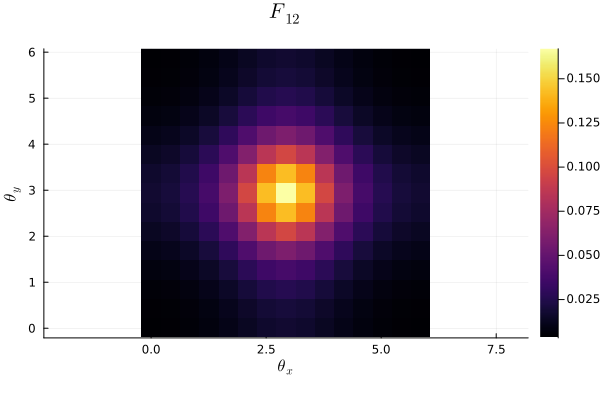

In [9]:
band_idx = 1
heatmap(Tx, Ty, imag(F12list[band_idx]), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)

# 2) Projected Single Particle

In [11]:
param_dict["sub_range"] = 1:3

sub_states = get_subset_states(H1, param_dict["sub_range"]);
subspace_proj, P, Pt = get_projector_op(basis, sub_states);
H1_proj = get_subspace_op(H1, P, Pt);
#param_dict["subspace_proj"] = subspace_proj
#param_dict["projection"] = subspace_proj, P, Pt;

## 2.1) Projected Single Particle Chern

In [12]:
EEA, UUA = calc_all_states_H1(param_dict);

In [13]:
bands = [[1,3]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

1-element Vector{Any}:
 1.0 - 1.2561547394593865e-17im

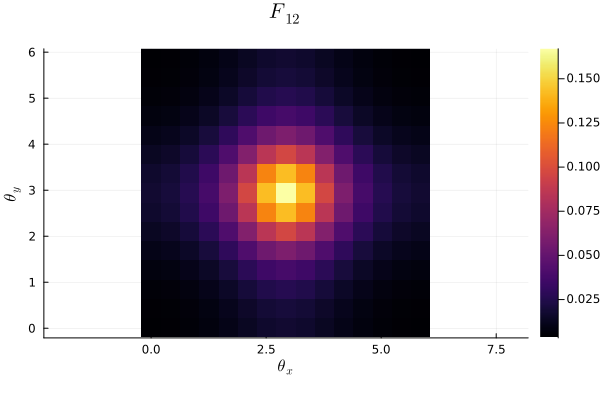

In [14]:
heatmap(Tx, Ty, imag(F12list), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)

# 3) Many Body

In [15]:
delete!(param_dict, "sub_range");

In [16]:
PN = 2
param_dict["PN"] = PN
basis_mb = get_basis_mb(param_dict)

ManyBody(onebodybasis=NLevel(N=9), states:45)

## 3.1) Non-Interacting Many Body

In [17]:
H1_mb = get_mb_op(basis_mb, H1);

In [18]:
param_dict["dimH_mb"] = length(basis_mb)
EEA, UUA = calc_all_states_H_mb(param_dict);

In [19]:
H_mb = get_H_mb(param_dict);

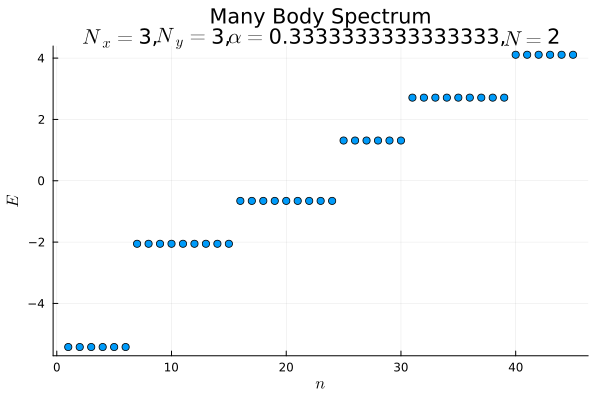

In [20]:
scatter(real(EEA[15,15,:]),legend=false,xlabel=L"n",ylabel=L"E")
#scatter!(real(EEA[1,1,:]))
title!("Many Body Spectrum\n"*L"N_x="*"$(LL[1]),"*L"N_y="*"$(LL[2]),"*L"\alpha="*"$(p/q),"*L"N="*"$(PN)")

In [21]:
EEA[1,1,15:20]

6-element Vector{Float64}:
 -1.999999999999991
 -0.7320508075688842
 -0.7320508075688829
 -0.7320508075688786
 -0.7320508075688777
 -0.7320508075688772

### 3.1.1) Non-Interacting Many Body Chern

In [22]:
#bands = [[1,6]]
bands = [[1,6], [7,15], [16,24], [25,30], [31,39], [40,45]]
#bands = [[1,5], [6,10], [11,15], [16,20], [21,25]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

6-element Vector{Any}:
   4.000000000000001 - 9.313307569152817e-16im
 -3.0000000000000013 + 9.857592758172353e-17im
  2.0000000000000004 + 2.960329914090596e-16im
  -3.999999999999999 + 1.1597919749066361e-17im
                -3.0 - 3.654091855107513e-16im
   4.000000000000001 - 1.2601990238749526e-16im

In [33]:
sum(real(Chern))

1.7763568394002505e-15

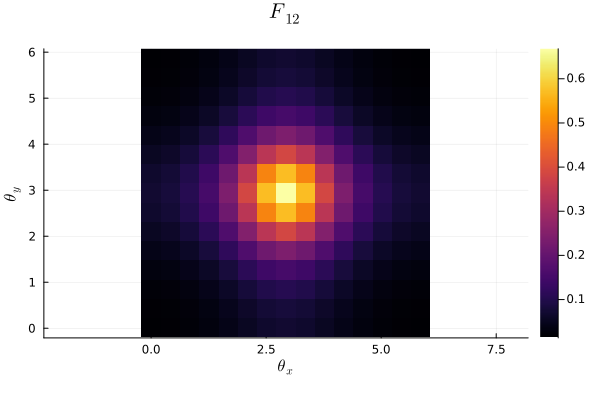

In [39]:
heatmap(Tx,Ty,imag(F12list[1]), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)
# Ortadaki bantlar için F düzgün değil!

## 3.2) Interacting Many Body

In [40]:
delete!(param_dict, "sub_range");

In [41]:
param_dict["U"] = 2 # U=0 iken yukarıda ki ile aynı
H_Finite, H_Int = get_Finite_U(param_dict)
#param_dict["θθ"]=[ Tx[2], Ty[2] ]
#Ee, Uu = eigenenergies(dense(H_Finite)) ## Hofstadter MB in Julia.ipynb ile farklı!
EEA, UUA = calc_all_states_H_mb_Finite_U(param_dict);

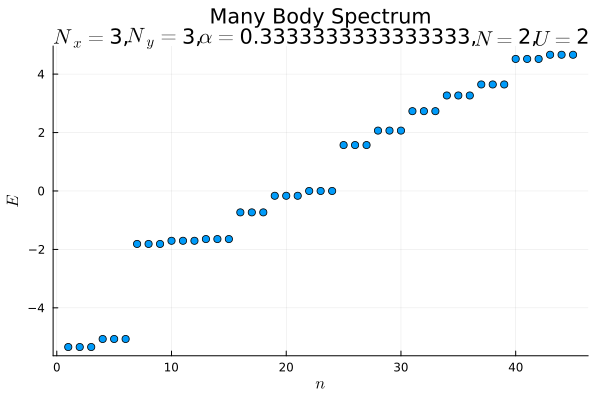

In [42]:
scatter(real(EEA[1,1,:]),legend=false,xlabel=L"n",ylabel=L"E")
#scatter!(real(EEA[15,15,:]))
title!("Many Body Spectrum\n"*L"N_x="*"$(LL[1]),"*L"N_y="*"$(LL[2]),"*L"\alpha="*"$(p/q),"*L"N="*"$(PN),"*L"U="*"$(param_dict["U"])")
#xlims!((0,5))

In [43]:
real(EEA[1,1,:])

45-element Vector{Float64}:
 -5.340971176014535
 -5.340971176014534
 -5.340971176014522
 -5.066168265618866
 -5.066168265618854
 -5.066168265618836
 -1.8128503544788677
 -1.8128503544788634
 -1.8128503544788632
 -1.7045703369311758
 -1.7045703369311702
 -1.704570336931168
 -1.6457513110645925
  ⋮
  3.2684826097554605
  3.268482609755461
  3.2684826097554613
  3.64575131106459
  3.6457513110645907
  3.645751311064591
  4.519542897531034
  4.519542897531036
  4.519542897531036
  4.662503113875361
  4.662503113875362
  4.662503113875362

### 3.2.1) Interacting Many Body Chern

In [44]:
bands = [[1,6]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern
# Hofstadter MB in Julia dosyası Chern ilk bandı da +4 üretiyor!

1-element Vector{Any}:
 3.9999999999999996 - 1.9101748456198905e-16im

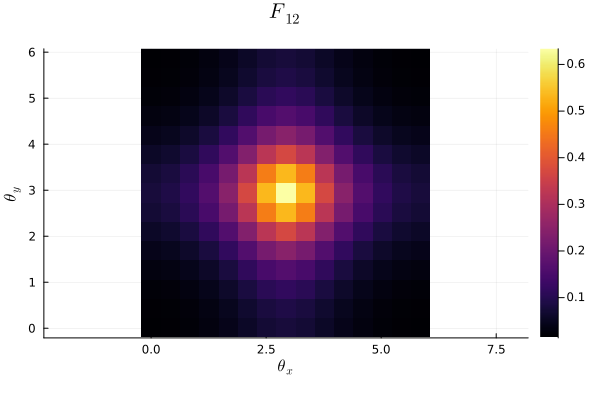

In [45]:
heatmap(Tx,Ty,imag(F12list), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)

# 4) Projected Interacting Many Body

In [46]:
param_dict["sub_range"] = 1:6;

In [47]:
param_dict["PN_int"] = [0, 1, 2]
cut_off = last(param_dict["sub_range"])
H_Total_Intt, basis_cut_mb = proj_MB_Int(param_dict);

In [48]:
EeE, UuU = eigenstates(dense((H_Total_Intt+H_Total_Intt')/2))
UuU_square = eigvecs(dense((H_Total_Intt+H_Total_Intt')/2).data)
EeE

28-element Vector{Float64}:
 -5.27988937154628
 -5.279889371546276
 -5.2798893715462745
 -4.979891727109167
 -4.97989172710916
 -4.979891727109158
 -2.7107276887968768
 -2.710727688796876
 -2.7107276887968754
 -1.7949877556102967
 -1.7949877556102907
 -1.7949877556102896
 -1.7349514920777074
  ⋮
 -1.3092687609617568
 -1.309268760961754
  0.0
  0.6561024141075441
  0.6561024141075494
  0.6561024141075507
  1.5581981460888075
  1.558198146088809
  1.5581981460888106
  1.8250807050577704
  1.8250807050577709
  1.8250807050577724

In [49]:
pn = 2
df = get_energies(pn, EeE, UuU, basis_cut_mb)
EE_res = Matrix(df)[:,2]

21-element Vector{Float64}:
 -5.27988937154628
 -5.279889371546276
 -5.2798893715462745
 -4.979891727109167
 -4.97989172710916
 -4.979891727109158
 -1.7949877556102967
 -1.7949877556102907
 -1.7949877556102896
 -1.7349514920777074
 -1.734951492077701
 -1.7349514920776963
 -1.309268760961759
 -1.3092687609617568
 -1.309268760961754
  1.5581981460888075
  1.558198146088809
  1.5581981460888106
  1.8250807050577704
  1.8250807050577709
  1.8250807050577724

In [50]:
function restricted_hubbard_states(filtered_E, UuU)
    number_of_states = length(EE_res)
    return UuU[:,1:number_of_states]
end
UU_res = restricted_hubbard_states(EE_res, UuU_square);

## 4.1) Projected Many Body Chern

In [51]:
param_dict["dimH_mb_int"] = length(basis_cut_mb)
EE_res, UU_res = calc_all_states_H_mb_Int(param_dict);

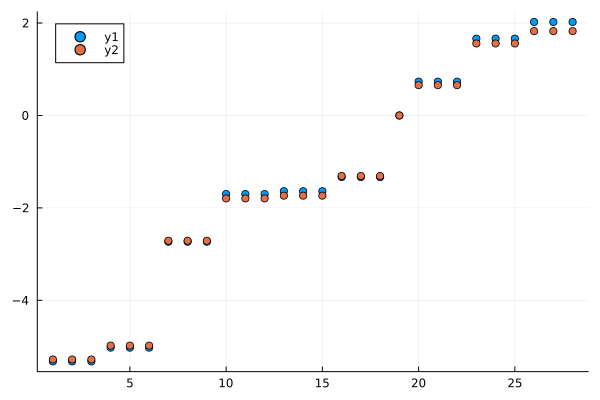

In [52]:
scatter(EE_res[1,1,:])
scatter!(EE_res[15,15,:])

In [171]:
EE_res[1,1,:] # E'ler Hofstadter First Band Approximation dosyasında ki ile aynı

21-element Vector{Float64}:
 -5.899676316747051
 -5.898901266861569
 -5.780537450040101
 -5.780537450040085
 -5.717031083773346
 -5.717031083773329
 -5.697061278642302
 -5.695329765455782
 -5.641213532431007
 -5.634252720034245
 -4.089901673865033
 -3.928665258599576
 -3.9286652585995707
 -3.7565425676158473
 -2.9664479891433717
 -2.9513559475485867
 -2.9513559475485844
 -2.93564881904323
 -2.1815184999015798
 -1.1755705045849472
  0.0

In [53]:
bands = [[1,6]]
Chern, F12list = calc_chern_bands(UU_res[:,:,:,1:6], bands);
Chern

1-element Vector{Any}:
 2.7056801977727836e-17 - 3.703981052329334e-18im

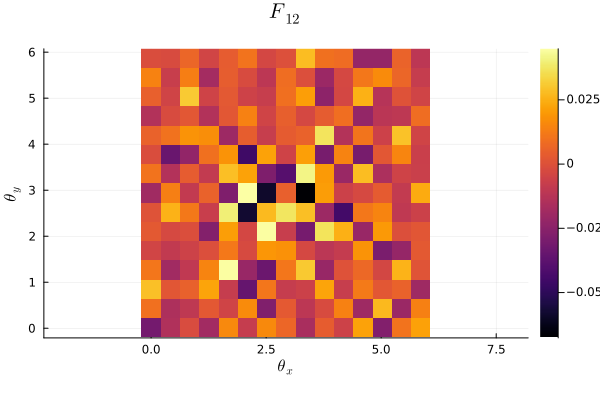

In [54]:
heatmap(Tx, Ty, imag(F12list), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)

In [102]:
param_dict["θθ"] = [0, 0];

In [27]:
H_T = get_Hofstadter_hamiltonian(param_dict);
H1 = get_sp_op(basis, H_T);
sub_states = get_subset_states(H1, param_dict["sub_range"])

subspace_proj, P, Pt = get_projector_op(basis, sub_states);
param_dict["projection"] = subspace_proj, P, Pt;

get_H_mb(param_dict)

Operator(dim=45x45)
  basis: ManyBody(onebodybasis=NLevel(N=9), states:45)sparse([1, 2, 3, 1, 2, 3, 10, 11, 1, 2  …  21, 7, 15, 22, 8, 16, 23, 9, 17, 24], [1, 1, 1, 2, 2, 2, 2, 2, 3, 3  …  21, 22, 22, 22, 23, 23, 23, 24, 24, 24], ComplexF64[-5.448709963501725 + 0.0im, 4.4e-16 + 0.0im, -6.0e-17 + 1.2e-16im, 4.4e-16 + 0.0im, -5.448709963501723 + 0.0im, 4.0e-17 + 9.0e-17im, 4.4e-16 + 0.0im, -4.0e-17 + 8.0e-17im, -6.0e-17 - 1.2e-16im, 4.0e-17 - 9.0e-17im  …  -2.724354981750859 + 0.0im, -4.0e-17 - 8.0e-17im, 4.0e-17 - 9.0e-17im, -2.724354981750859 + 0.0im, -4.0e-17 - 8.0e-17im, 4.0e-17 - 9.0e-17im, -2.724354981750859 + 0.0im, -4.0e-17 - 8.0e-17im, 4.0e-17 - 9.0e-17im, -2.724354981750859 + 0.0im], 45, 45)

In [104]:
PN = 2
param_dict["PN"] = PN
basis_mb_chern = get_basis_mb(param_dict);
param_dict["basis_mb"] = basis_mb_chern

ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), states:3), states:6)

In [105]:
param_dict["dimH_mb"] = length(basis_mb_chern)

6

In [106]:
param_dict["θθ"] = [0, 1.1];

In [107]:
H_mb_Chern_basis = get_H_mb(param_dict); 

In [108]:
# #H_T = get_Hofstadter_hamiltonian(param_dict);

# H1 = get_sp_op(basis, H_T);
# sub_states = get_subset_states(H1, param_dict["sub_range"])
# subspace_proj, P, Pt = get_projector_op(basis, sub_states);
# param_dict["projection"] = subspace_proj, P, Pt;

basis_mb_1 = get_basis_mb(param_dict);

In [109]:
H_mb_1 = get_H_mb(param_dict);

In [110]:
H_mb_Chern_basis == H_mb_1

true

In [111]:
basis_mb_1

ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), states:3), states:6)

In [112]:
basis_mb_chern

ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), states:3), states:6)

In [113]:
U = get_mb_op(basis_mb_chern, P);
U

Operator(dim=6x6)
  basis: ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), states:3), states:6)sparse([1, 2, 3, 1, 2, 3, 4, 5, 1, 2  …  4, 5, 2, 3, 4, 5, 6, 3, 5, 6], [1, 1, 1, 2, 2, 2, 2, 2, 3, 3  …  4, 4, 5, 5, 5, 5, 5, 6, 6, 6], ComplexF64[-0.23829244179720815 + 1.0143116485190087im, 0.07471462268067121 + 0.1294095225512606im, -0.3018546800913304 - 0.10205692203302481im, -0.29731743702232843 + 0.6709529134395199im, -0.06631500454730721 + 0.4156494733133944im, 0.07879241070598719 + 0.21603889570766988im, 0.07471462268067121 + 0.1294095225512606im, -0.21344349122547565 - 0.07216514163657863im, -0.1874377184233606 + 0.5552600960652501im, 0.39433756729740654 - 2.0e-17im  …  0.1056624327025937 - 0.18301270189221971im, 0.11142929583247815 + 0.30552513630989336im, -0.13253848174729294 + 0.39262817925003207im, -0.21023517588349272 + 0.47443535494995515im, 0.5576775358252055 - 2.0e-17im, 0.109035499375374 - 0.1458106660230292im, 0.11142929583247815 + 0.30552513630989336im, -0.18743771

In [114]:
H_mb_Chern_basis

Operator(dim=6x6)
  basis: ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), states:3), states:6)sparse([1, 2, 3, 1, 2, 3, 4, 5, 1, 2  …  4, 5, 2, 3, 4, 5, 6, 3, 5, 6], [1, 1, 1, 2, 2, 2, 2, 2, 3, 3  …  4, 4, 5, 5, 5, 5, 5, 6, 6, 6], ComplexF64[-4.833656291278133 + 0.0im, -0.00062305468097189 - 0.00314871122431113im, -0.00779650749652046 - 0.00512812914309899im, -0.00062305468097189 + 0.00314871122431113im, -4.85454477037374 + 0.0im, -0.04308390367031367 + 0.04380016379758636im, -0.00062305468097189 - 0.00314871122431113im, -0.00551296332036137 - 0.00362613489188565im, -0.00779650749652046 + 0.00512812914309899im, -0.04308390367031367 - 0.04380016379758636im  …  -4.875433249469348 + 0.0im, -0.06092984089053357 + 0.06194278567670968im, -0.00551296332036137 + 0.00362613489188565im, -0.00044056618996524 + 0.0022264750587086im, -0.06092984089053357 - 0.06194278567670968im, -5.0329226982085595 + 0.0im, -0.06092984089053357 + 0.06194278567670968im, -0.00779650749652046 + 0.0051281291430

## Projected Non-Interacting Many Body

In [115]:
EEA, UUA = calc_all_states_H_mb(param_dict);

In [116]:
#param_dict["model_H1"] = H_mb_Chern_basis;

In [117]:
param_dict

Dict{Any, Any} with 23 entries:
  "pbc"            => true
  "neighbors_list" => [[[1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]]]
  "site_number"    => Dict{Any, Any}([2, 2, 1]=>9, [2, 1, 1]=>6, [1, 0, 1]=>2, …
  "Tx"             => [0.0, 0.314159, 0.628319, 0.942478, 1.25664, 1.5708, 1.88…
  "param_2"        => "Ty"
  "θθ"             => [5.96903, 5.96903]
  "t"              => -1
  "Ty"             => [0.0, 0.314159, 0.628319, 0.942478, 1.25664, 1.5708, 1.88…
  "PN"             => 2
  "model_H1"       => get_Hofstadter_hamiltonian
  "vv_basis"       => [[0, 0]]
  "basis_mb"       => ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), st…
  "LL"             => [3, 3]
  "ϕ"              => 0.333333
  "sub_range"      => 1:3
  "basis"          => NLevel(N=9)
  "projection"     => (Subspace(superbasis=NLevel(N=9), states:3), Operator(dim…
  "dimH_mb"        => 6
  "vv_lattice"     => [[1.0, 0.0], [0.0, 1.0]]
  "gauge"          => "Landau"
  "sites"          => Any[[0, 0, 1], [1, 0, 1]

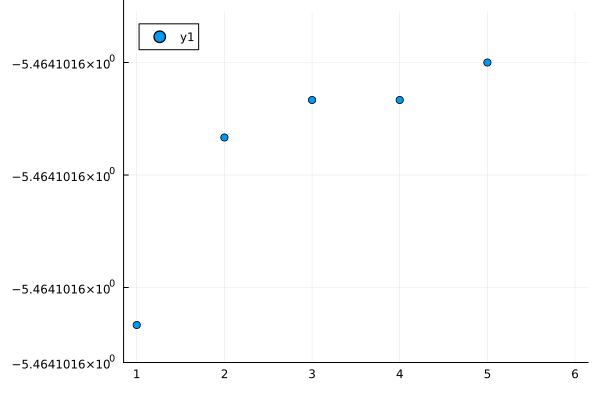

In [118]:
scatter(EEA[1,1,:])#, ylimits=(-6,-4))

### Projected Many Body Chern

In [121]:
#bands = [[1,6], [7,15], [16,21]]
#bands = [[1,3], [4,6]]
#bands = [[1,3]]
bands = [[1,6]]
#bands = [[1,5],[6,10],[11,15]]
#bands = [[1,5]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

1-element Vector{Any}:
 2.2046029658029097e-16 - 1.413579858428226e-16im

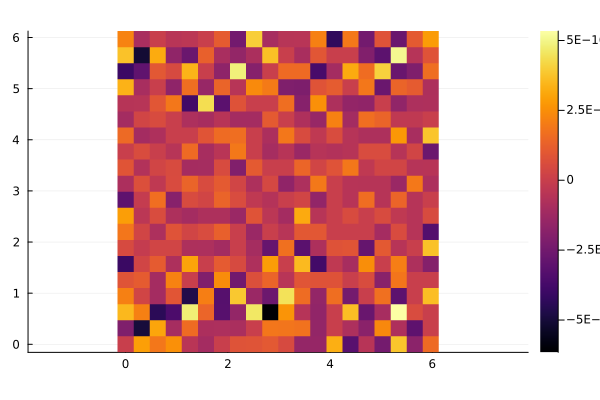

In [123]:
heatmap(Tx,Ty,imag(F12list),aspect_ratio=1)

## Transformed single particle basis

In [124]:
param_dict["sub_range"] = 1:3;

In [125]:
param_dict["θθ"] = [0, 0];

In [126]:
H_T = get_Hofstadter_hamiltonian(param_dict);
H1 = get_sp_op(basis, H_T);
sub_states = get_subset_states(H1, param_dict["sub_range"])

subspace_proj, P, Pt = get_projector_op(basis, sub_states);
param_dict["projection_chern"] = subspace_proj, P, Pt;

In [127]:
PN = 2
param_dict["PN"] = PN
basis_mb_chern = get_basis_mb(param_dict);
param_dict["basis_mb_chern"] = basis_mb_chern
param_dict["dimH_mb"] = length(basis_mb_chern)

6

In [128]:
mb_states_chern = bosonstates(param_dict["projection_chern"][1], param_dict["PN"]);
param_dict["mb_states_chern"] = mb_states_chern

6-element Vector{Vector{Int64}}:
 [2, 0, 0]
 [1, 1, 0]
 [1, 0, 1]
 [0, 2, 0]
 [0, 1, 1]
 [0, 0, 2]

In [129]:
param_dict["θθ"] = [0, 1.1];

In [130]:
H_T = get_Hofstadter_hamiltonian(param_dict);
H1 = get_sp_op(basis, H_T);
sub_states = get_subset_states(H1, param_dict["sub_range"])

subspace_proj, P, Pt = get_projector_op(basis, sub_states);
param_dict["projection"] = subspace_proj, P, Pt;

In [131]:
basis_mb = get_basis_mb(param_dict);
param_dict["basis_mb"] = basis_mb
mb_states = bosonstates(param_dict["projection"][1], param_dict["PN"]);
param_dict["mb_states"] = mb_states

6-element Vector{Vector{Int64}}:
 [2, 0, 0]
 [1, 1, 0]
 [1, 0, 1]
 [0, 2, 0]
 [0, 1, 1]
 [0, 0, 2]

In [132]:
param_dict["projection_chern"][2]*param_dict["projection"][2]'

Operator(dim=3x3)
  basis left:  Subspace(superbasis=NLevel(N=9), states:3)
  basis right: Subspace(superbasis=NLevel(N=9), states:3)
   0.671778+0.609258im    0.188834-0.0431921im     0.209173-0.169895im
   -0.13417-0.139419im    0.933827-0.167325im    -0.0151595+0.0305664im
 -0.0987628-0.258509im  -0.0187952-0.00529495im    0.931108-0.20006im

In [133]:
param_dict["projection"][2]*param_dict["projection_chern"][2]'

Operator(dim=3x3)
  basis left:  Subspace(superbasis=NLevel(N=9), states:3)
  basis right: Subspace(superbasis=NLevel(N=9), states:3)
 0.671778-0.609258im     -0.13417+0.139419im   -0.0987628+0.258509im
 0.188834+0.0431921im    0.933827+0.167325im   -0.0187952+0.00529495im
 0.209173+0.169895im   -0.0151595-0.0305664im    0.931108+0.20006im

In [134]:
get_state_list(mb_states_chern)

(Any[Any[1, 1], Any[1, 2], Any[1, 3], Any[2, 2], Any[2, 3], Any[3, 3]], Any[0.7071067811865475, 1.0, 1.0, 0.7071067811865475, 1.0, 0.7071067811865475])

In [135]:
EEA, UUA = calc_all_states_H_mb_2(param_dict);

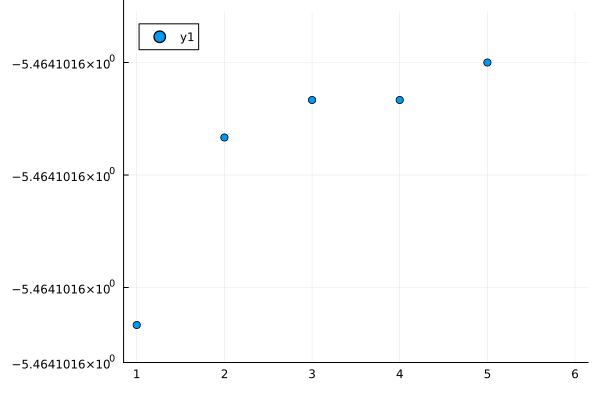

In [136]:
scatter(EEA[1,1,:])#, ylimits=(-6,-4))

In [137]:
bands = [[1,6]]
#bands = [[1,5],[6,10],[11,15]]
#bands = [[1,5]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

1-element Vector{Any}:
 0.9999999999999999 - 3.175032886486898e-18im